<a href="https://colab.research.google.com/github/SamPIngram/PyFoci_Colab/blob/main/PyFociExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Set-up enviroment for running PyFoci**

*After installing the packages you may be prompted to restart runtime.*


In [1]:
#@markdown ## **Download required Libraries**
!git clone https://gitlab.com/PRECISE-RT/releases/pyfoci.git
%cd pyfoci
!pip install -r requirements.txt
import pyfoci
%cd ..

Cloning into 'pyfoci'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 100 (delta 25), reused 87 (delta 17), pack-reused 0
Receiving objects: 100% (100/100), 83.53 MiB | 27.29 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/pyfoci
/content


# **2. Pick Microscope Settings**

These options are for the microscopes included from *Ingram et al., A computational approach to quantifying miscounting of radiation-induced double-strand break immunofluorescent foci. In Review.* Pick the microscope you want to emulate from the form below, this will show available mangifications on the cell below. Select which magniciation you wish to use a move on. The users own microscope PSF can be added to PyFoci through modiction of the /content/pyfoci/pyfoci/microscopes/Microscopes.json file which will need to point to the captured .h5 distilled PSF data.

In [2]:
import ipywidgets as widgets
import json
with open('/content/pyfoci/pyfoci/microscopes/Microscopes.json', 'r') as f:
  microscope_specs = json.load(f)

#@title Microscope
microscope = "airyscan" #@param ["airyscan", "gSTED", "Lowlight", "MultiPhoton", "Phenix", "STED"]

In [3]:
#@title Magnification

magnifications = microscope_specs['PSF_file'][microscope].keys()
mag_picker = widgets.Dropdown(options=magnifications)
display(mag_picker)

Dropdown(options=('10x', '20x', '40x', '63x', '100x'), value='10x')

# **3. Download Simulated DNA Damage and Repair Data**

This data will be downloaded from FigShare data store which corresponds to the data used in *Ingram et al., A computational approach to quantifying miscounting of radiation-induced double-strand break immunofluorescent foci. In Review.* Pick the setting you want to emulate from the form below. These are just a sample of the included data and this toolset can be used with the users own data if available.

In [4]:
#@title Download Data
!wget -q -O Vertices.zip https://figshare.com/ndownloader/files/27522164?private_link=ae99c2d5888604e16eec
!unzip -q Vertices.zip
!rm Vertices.zip
!wget -q -O SDDs.zip https://figshare.com/ndownloader/files/27522179?private_link=ae99c2d5888604e16eec
!unzip -q SDDs.zip
!rm SDDs.zip
!wget -q -O Repair.zip https://figshare.com/ndownloader/files/27522185?private_link=ae99c2d5888604e16eec
!unzip -q Repair.zip
!rm Repair.zip

In [5]:
#@title Set Radiation Parameters
radiation_type = "proton" #@param ["photon", "proton"]
dose = "2 Gy" #@param ["1 Gy", "2 Gy", "5 Gy", "10 Gy"]
#@markdown Protons only setting:
energy = "34.0 MeV" #@param ["0.975 MeV", "5.5 MeV", "34.0 MeV"]

dose_value = dose.split(' ')[0]
if radiation_type == "photon":
  energy_value = 10.0
else:
  energy_value = energy.split(' ')[0]

# **4. Emulation Settings**
These settings will be used by PyFoci to emulate the microscope image that can be used for benchmarking the users foci counting.

In [42]:
#@title Emulation Parameters
flourescent_marker = "gH2AX" #@param ["gH2AX", "Ku/DNA-PKcs"]
time_point_seconds = 1800 #@param {type:"integer"}
labelling_efficiency_percentage = 3 #@param {type:"slider", min:0, max:100, step:1}
labelling_efficiency = labelling_efficiency_percentage/100
z_stack_offset = 0 #@param {type:"integer"}
normalise_intensity = False #@param {type:"boolean"}
cell_example_id = 34 #@param {type:"slider", min:1, max:200, step:1}

#@markdown **gH2AX Only**

#@markdown ---

#@markdown Settings for H2AX postioning
nucleosome_size_bp = 146 #@param {type:"integer"}
histone_copies_per_nucleosome = 2 #@param {type:"integer"}
percentage_h2ax = 10 #@param {type:"slider", min:0, max:100, step:1}

#@markdown Settings for H2AX activation via Cauchy Distribution
A = 0.22568542777797262 #@param {type:"number"}
H = 0.3848433186715101 #@param {type:"number"}
FWHM = 0.4488695944536109 #@param {type:"number"}


# **5. Run PyFoci**


In [43]:
#@title Generate Damage File (~10mins for gH2AX)

import numpy as np
import shutil

def make_H2AX_file(damaris_file):
    damaris = damaris_file
    geom_id = damaris.split('/')[-1].split('MicroscopeSnapshots')[1].split('.')[0]
    bead_verticies = f'/content/Vertices/IMR90_Ellipsoid_noLADs_zFlat_{geom_id}.vertices.txt'

    sim_times, xs, ys, zs, _, het, chrom, chromatid, _, chrompos, breakid = np.loadtxt(damaris, delimiter=' ', unpack=True)
    bio_base = pyfoci.bioProcessing.BioProcessing()
    bio_base.read_bead_verticies_file(bead_verticies)
    bio_base.filter_beads_by_damage_only(damaris, 0, etol=1e-3)
    bio_base.add_histones(seed=0, nucleosome_size_bp=nucleosome_size_bp, histone_copies_per_nucleosome=histone_copies_per_nucleosome, fraction_h2ax=percentage_h2ax/100, labelling_efficiency=labelling_efficiency)
    bio_base.compute_histone_activation()
    bio_base.store_data(0)
    time_list = [time_point_seconds]
    for time in time_list:
        bio_base.update_damage(damaris, time, noMovement=True)
        bio_base.compute_histone_activation(reset_vals=True, A=A, H=H, FWHM=FWHM)
        bio_base.store_data(time)

    saveName = f'/content/damagefile'
    bio_base.save_as_npy(save_name=saveName)

if flourescent_marker == "gH2AX":
  make_H2AX_file(f'/content/Repair - DSBMarker/{radiation_type}/{energy_value}/{dose_value}/MicroscopeSnapshots{cell_example_id}.out')
  damage_path = '/content/damagefile.npz'

shutil.copyfile(f'/content/Repair - DSBMarker/{radiation_type}/{energy_value}/{dose_value}/MicroscopeSnapshots{cell_example_id}.out', '/content/damagefile.out')
damage_path_dsbs = '/content/damagefile.out'

70


In [37]:
#@title Run PyFoci Simulation
%cd pyfoci
def simulate(damagefile, microscope_setting, microscope_name, magnification, time, z_stack_offset):
  microscope_object = pyfoci.microscope.Microscope(damagefile, microscope_setting, cell_radius=14)
  microscope_object.define_microscope_list(microscope_name, magnification)
  world = microscope_object.create_world()
  microscope_object.mapping_breaks()
  scored_world = microscope_object.place_breaks(world, time, z_stack_offset=z_stack_offset)
  microscope_object.max_value_world()
  return microscope_object, scored_world

microscope_file = '/content/pyfoci/pyfoci/microscopes/Microscopes.json'
if flourescent_marker == "gH2AX":
  microscope_object, scored_world = simulate(damage_path_dsbs, microscope_file, microscope, mag_picker.value, time_point_seconds, z_stack_offset)
  breaks_in_slice = microscope_object.breaks_in_slice
  microscope_object, scored_world = simulate(damage_path, microscope_file, microscope, mag_picker.value, time_point_seconds, z_stack_offset)
else:
  microscope_object, scored_world = simulate(damage_path_dsbs, microscope_file, microscope, mag_picker.value, time_point_seconds, z_stack_offset)
  breaks_in_slice = microscope_object.breaks_in_slice
%cd ..

/content/pyfoci
/content


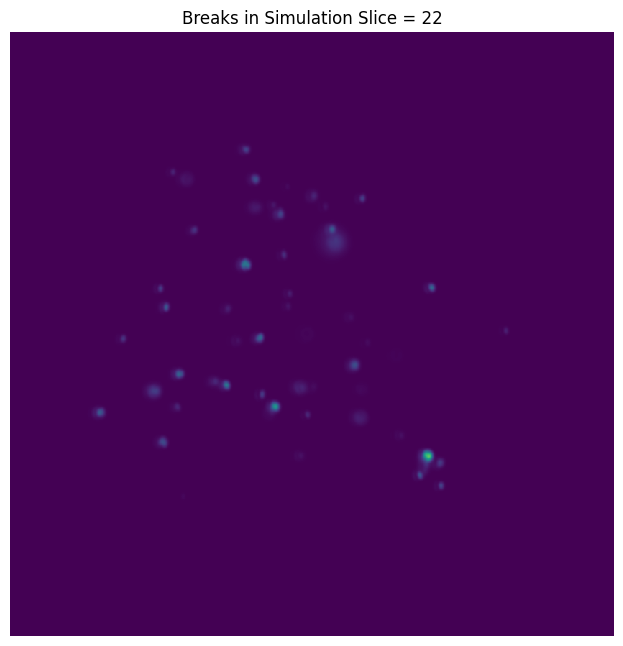

In [33]:
#@title Visualise Results
from matplotlib.pyplot import figure, title

figure(figsize=(8, 8), dpi=100)

def view(microscope_object, scored_world, normalise_intensity):
  view = pyfoci.view.View(microscope_object, scored_world)
  view.viewer()
  view.display_microscope_image(self_normalisation=normalise_intensity)
  return view

title(f"Breaks in Simulation Slice = {breaks_in_slice}")
view = view(microscope_object, scored_world, normalise_intensity)

# **6. Download Output for Benchmarking**

In [38]:
from google.colab import files
import os

if not os.path.isdir('/content/results'):
  os.mkdir('/content/results')
#@title Download Image for Benchmarking
Format = "png" #@param ["png", "tiff", "pdf", "svg", "jpeg"]
DPI = 500 #@param {type:"integer"}

view.save_microscope_image(f'BIS{breaks_in_slice}_{dose}_{energy}_{time_point_seconds}s_CellID{cell_example_id}.{Format}', save_path='/content/results', dpi=DPI)

filename = os.listdir('/content/results')
files.download('/content/results/'+filename[0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

# **7. (Optional) In-built Foci Counting**

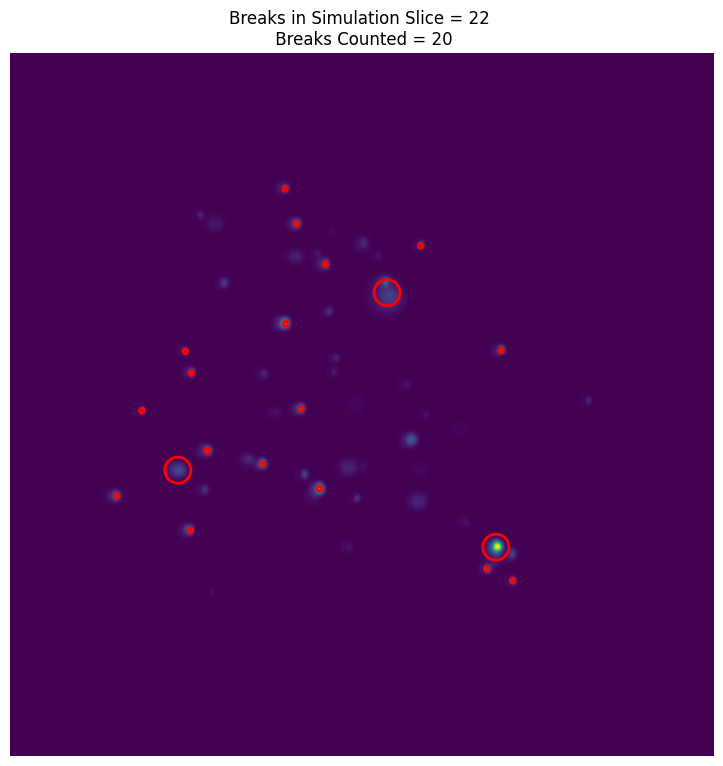

In [16]:
#@title Foci Counter Parameters
min_sigma = 2 #@param {type:"integer"}
max_sigma = 20 #@param {type:"integer"}
num_sigma = 3 #@param {type:"integer"}
percentage_of_max_val_threshold = 6 #@param {type:"slider", min:1, max:100, step:1}
threshold = percentage_of_max_val_threshold/100

figure(figsize=(8, 8), dpi=100)

counter = pyfoci.fociCounter.FociCounter()
counter.parse_input(view.view_adjusted_image)
counter.detect_foci(min_sigma=min_sigma, max_sigma=max_sigma, num_sigma=num_sigma, threshold=microscope_object.max_value*threshold)
title(f"Breaks in Simulation Slice = {breaks_in_slice} \n Breaks Counted = {counter.detections}")
counter.plot_detected_array()
